In [152]:
import os
import numpy as np
import re
import pickle as pkl
import spacy
import string
import random
from collections import Counter
import time
import numpy as np
import torch
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F

#seems like nltk would be faster
spacy.__version__
from spacy.lang.en.stop_words import STOP_WORDS

#!pip install BeautifulSoup4
#use BeautifulSoup to remove html tag
from bs4 import BeautifulSoup

In [124]:
def convert(data_list):
    #0 is neg, 1 is pos
    return [0 if i =='neg' else 1 for i in data_list]

In [125]:
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

#use default vocab_size = 10000, can be over-written later
max_vocab_size = 10000

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token


In [126]:
# convert token to id in the dataset
# convert a sentence into a sequnce of tokens
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [127]:
class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        #print(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]



In [128]:
class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    
    #emb_dim will make a lot difference
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

In [129]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [ ]:
#function adapt from torch.optim.lr_scheduler
class Linear_StepLR(_LRScheduler):

    def __init__(self, optimizer, step_size, gamma=0.1, last_epoch=-1):
        self.step_size = step_size
        self.gamma = gamma
        super(StepLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr - self.gamma ** (self.last_epoch // self.step_size)
                for base_lr in self.base_lrs]

## Data Preparation

## obtain data

In [5]:
directoryPath ='./aclImdb'

In [4]:
#Load data
data = dict(train_data = [],
train_targets_class = [],
train_targets_values = [],

test_data = [],
test_targets_class = [],
test_targets_values = [])

In [5]:
data

{'train_data': [],
 'train_targets_class': [],
 'train_targets_values': [],
 'test_data': [],
 'test_targets_class': [],
 'test_targets_values': []}

In [6]:
folder_list = ['train/pos','train/neg','test/pos','test/neg']

for i in folder_list:
    print(i.split('/')[0])
    current_data = i.split('/')[0] + '_data'
    print(current_data)
    print(type(current_data))

train
train_data
<class 'str'>
train
train_data
<class 'str'>
test
test_data
<class 'str'>
test
test_data
<class 'str'>


In [7]:
folder_list = ['train/pos','train/neg','test/pos','test/neg']

for folder in folder_list:
    current_data_section = folder.split('/')[0]
    print(current_data_section)
    current_data_label = folder.split('/')[1]
    print(current_data_label)
    subfolder = os.path.join(directoryPath,folder)
    print(subfolder)
    for file in os.listdir(subfolder):
        #print(file)
        score = file.split('_')[1].split('.')[0]
        #print(score)
        current_data = current_data_section+'_data'
        #print(current_data)
        current_target_class = current_data_section + '_targets_class'
        #print(current_target_class)
        current_target_values = current_data_section + '_targets_values'
        #print(current_target_values)
        try:
            score = int(score)
            #print(score)
            data[current_target_class].append(current_data_label)
            data[current_target_values].append(score)
            with open(os.path.join(subfolder,file)) as file:
                data[current_data].append(file.read())
        except:
            print('skip example {}'.format(os.path.join(subfolder,file)))


    

train
pos
./aclImdb/train/pos
train
neg
./aclImdb/train/neg
test
pos
./aclImdb/test/pos
test
neg
./aclImdb/test/neg


In [8]:
train_data = data['train_data']
train_targets_class = data['train_targets_class']
train_targets_values = data['train_targets_values']
test_data = data['test_data']
test_targets_class = data['test_targets_class']
test_targets_values = data['test_targets_values']

In [9]:
#shuffle the train data
#train validation split: as suggested 20000 vs 5000

c = list(zip(train_data, train_targets_class,train_targets_values))
random.shuffle(c)
train_data, train_targets_class, train_targets_values = zip(*c)


In [10]:
train_split = 20000

val_data = train_data[train_split:]
val_targets_class = train_targets_class[train_split:]
val_targets_values = train_targets_values[train_split:]

train_data = train_data[:train_split]
train_targets_class = train_targets_class[:train_split]
train_targets_values = train_targets_values[:train_split]

In [117]:
pkl.dump(list(train_data), open("train_data.p", "wb"))
pkl.dump(list(train_targets_class), open("train_targets_class.p", "wb"))
pkl.dump(list(train_targets_values), open("train_targets_values.p", "wb"))
pkl.dump(list(val_data), open("val_data.p", "wb"))
pkl.dump(list(val_targets_class), open("val_targets_class.p", "wb"))
pkl.dump(list(val_targets_values), open("val_targets_values.p", "wb"))
pkl.dump(list(test_data), open("test_data.p", "wb"))
pkl.dump(list(test_targets_class), open("test_targets_class.p", "wb"))
pkl.dump(list(test_targets_values), open("test_targets_values.p", "wb"))

In [ ]:
########################################################################
########################################################################

## Experiment with different tokenization schemes

In [41]:
train_data = pkl.load(open("train_data.p", "rb"))
train_targets_class = pkl.load(open("train_targets_class.p", "rb"))
train_targets_values = pkl.load(open("train_targets_values.p", "rb"))
val_data = pkl.load(open("val_data.p", "rb"))
val_targets_class = pkl.load(open("val_targets_class.p", "rb"))
val_targets_values = pkl.load(open("val_targets_values.p", "rb"))
test_data = pkl.load(open("test_data.p","rb"))
test_targets_class = pkl.load(open("test_targets_class.p", "rb"))
test_targets_values = pkl.load(open("test_targets_values.p", "rb"))

In [42]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation


In [53]:
def tokenize_dataset(dataset, scheme_id, n_gram):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize_ngram(sample, scheme_id, n_gram)
        token_dataset.append(tokens)
        all_tokens += tokens
    #all token is list 
    #token_dataset is list of list
    return token_dataset, all_tokens

In [46]:
#make n-gram
def make_ngram(sent, n_gram):
    #remove punctuation and lower case
    sent = BeautifulSoup(sent).get_text()
    sent = re.sub('\n', '', sent)
    tokens = tokenizer(sent)
    sent = [token.text.lower() for token in tokens if (token.text not in punctuations)]
    return_list = []
    for n in range(2,n_gram+1):
        return_list += [sent[i:i+n] for i in range(len(sent)-(n-1))]
        
    return ['_'.join(i) for i in return_list]
    

In [48]:
STOPLIST = list(STOP_WORDS)
def tokenize_ngram(sent, scheme_id, n_gram):
    sent = BeautifulSoup(sent).get_text()
    sent = re.sub('\n', '', sent)
    tokens = tokenizer(sent)
    if scheme_id == 1 :
        return_list= [token.text for token in tokens]
    elif scheme_id == 2 :
        return_list = [token.text.lower() for token in tokens if (token.text not in punctuations)]
    elif scheme_id == 3 :
        return_list = [token.text.lower() for token in tokens if ((token.text not in punctuations) & (token.text not in STOPLIST))]
    elif scheme_id == 4 :
        return_list = [token.lemma_.lower() for token in tokens if ((token.text not in punctuations) & (token.text not in STOPLIST))]
    else:
        print('not a valide scheme')
    
    if n_gram > 1:
        return return_list + make_ngram(sent, n_gram)
    else:
        return return_list

In [49]:
# Example
tokens = tokenize_ngram(u'Apple is looking at buying U.K. startup for $1 billion',1,1)
print (tokens)

['Apple', 'is', 'looking', 'at', 'buying', 'U.K.', 'startup', 'for', '$', '1', 'billion']


In [50]:
# Example
tokens = tokenize_ngram(u'Apple is looking at buying U.K. startup for $1 billion',2,3)
print (tokens)

['apple', 'is', 'looking', 'at', 'buying', 'u.k.', 'startup', 'for', '1', 'billion', 'apple_is', 'is_looking', 'looking_at', 'at_buying', 'buying_u.k.', 'u.k._startup', 'startup_for', 'for_1', '1_billion', 'apple_is_looking', 'is_looking_at', 'looking_at_buying', 'at_buying_u.k.', 'buying_u.k._startup', 'u.k._startup_for', 'startup_for_1', 'for_1_billion']


In [51]:
# Example
tokens = tokenize_ngram(u'Apple is looking at buying U.K. startup for $1 billion',3,2)
print (tokens)

['apple', 'looking', 'buying', 'u.k.', 'startup', '1', 'billion', 'apple_is', 'is_looking', 'looking_at', 'at_buying', 'buying_u.k.', 'u.k._startup', 'startup_for', 'for_1', '1_billion']


In [52]:
# Example
tokens = tokenize_ngram(u'Apples is looking at buying U.K. startup for $1 billion',4,2)
print (tokens)

['apple', 'look', 'buy', 'u.k.', 'startup', '1', 'billion', 'apples_is', 'is_looking', 'looking_at', 'at_buying', 'buying_u.k.', 'u.k._startup', 'startup_for', 'for_1', '1_billion']


In [58]:
#############run this block for different schemes by passing the parameters

#tokenizing scheme1:
# val set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(val_data,3,4)
pkl.dump(val_data_tokens, open("val_data_tokens_scheme3_4gram.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_data,3,4)
pkl.dump(test_data_tokens, open("test_data_tokens_scheme3_4gram.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(train_data,3,4)
pkl.dump(train_data_tokens, open("train_data_tokens_scheme3_4gram.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_tokens_scheme3_4gram.p", "wb"))

Tokenizing val data
Tokenizing test data
Tokenizing train data


## Performance Experiments

In [118]:
train_targets_class = pkl.load(open("train_targets_class.p", "rb"))
train_targets_values = pkl.load(open("train_targets_values.p", "rb"))
val_targets_class = pkl.load(open("val_targets_class.p", "rb"))
val_targets_values = pkl.load(open("val_targets_values.p", "rb"))
test_targets_class = pkl.load(open("test_targets_class.p", "rb"))
test_targets_values = pkl.load(open("test_targets_values.p", "rb"))

#convert 'pos' into 1, 'neg' into 0
train_targets_class = convert(train_targets_class)
val_targets_class = convert(val_targets_class)
test_targets_class = convert(test_targets_class)

## experiment 1: scheme1_1gram

In [142]:
###Load corresponding data
# Then, load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open("train_data_tokens_scheme1_1gram.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_scheme1_1gram.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_scheme1_1gram.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_scheme1_1gram.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 5398126


In [143]:
#use default vocab_size = 10000
max_vocab_size = 10000
token2id, id2token = build_vocab(all_train_tokens)

In [145]:
# Lets check the dictionary by loading random token from it
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 3309 ; token upset
Token upset; token id 3309


In [146]:
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [149]:
#create dataloader
#better practice, pick 80% of the length distribution
MAX_SENTENCE_LENGTH = 200
BATCH_SIZE = 32

train_dataset = NewsGroupDataset(train_data_indices, train_targets_class)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets_class)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)


In [157]:
emb_dim = 100
model1 = BagOfWords(len(id2token), emb_dim)

In [158]:
learning_rate = 0.01
num_epochs = 10 
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

validation_accuracy_list_model1 = []
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model1.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model1(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model1)
            validation_accuracy_list_model1.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))


Epoch: [1/10], Step: [101/625], Validation Acc: 79.1
Epoch: [1/10], Step: [201/625], Validation Acc: 82.8
Epoch: [1/10], Step: [301/625], Validation Acc: 84.26
Epoch: [1/10], Step: [401/625], Validation Acc: 85.36
Epoch: [1/10], Step: [501/625], Validation Acc: 83.76
Epoch: [1/10], Step: [601/625], Validation Acc: 85.54
Epoch: [2/10], Step: [101/625], Validation Acc: 86.06
Epoch: [2/10], Step: [201/625], Validation Acc: 85.68
Epoch: [2/10], Step: [301/625], Validation Acc: 85.46
Epoch: [2/10], Step: [401/625], Validation Acc: 83.9
Epoch: [2/10], Step: [501/625], Validation Acc: 85.34
Epoch: [2/10], Step: [601/625], Validation Acc: 85.54
Epoch: [3/10], Step: [101/625], Validation Acc: 85.38
Epoch: [3/10], Step: [201/625], Validation Acc: 85.58
Epoch: [3/10], Step: [301/625], Validation Acc: 85.08
Epoch: [3/10], Step: [401/625], Validation Acc: 85.28
Epoch: [3/10], Step: [501/625], Validation Acc: 83.54
Epoch: [3/10], Step: [601/625], Validation Acc: 83.72
Epoch: [4/10], Step: [101/625],

In [170]:
np.mean(validation_accuracy_list_model1)

83.86566666666666

## Experiment with scheme2_1gram

In [160]:
###Load corresponding data
# Then, load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open("train_data_tokens_scheme2_1gram.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_scheme2_1gram.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_scheme2_1gram.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_scheme2_1gram.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4749113


In [161]:
max_vocab_size = 10000
token2id, id2token = build_vocab(all_train_tokens)

In [163]:
# Lets check the dictionary by loading random token from it
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 9806 ; token 5th
Token 5th; token id 9806


In [164]:
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [165]:
#create dataloader
#better practice, pick 80% of the length distribution
MAX_SENTENCE_LENGTH = 200
BATCH_SIZE = 32

train_dataset = NewsGroupDataset(train_data_indices, train_targets_class)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets_class)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets_class)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)


In [166]:
emb_dim = 100
model2 = BagOfWords(len(id2token), emb_dim)

In [167]:
learning_rate = 0.01
num_epochs = 10 
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)


validation_accuracy_list_model2 = []
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model2.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model2(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model2)
            validation_accuracy_list_model2.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))



Epoch: [1/10], Step: [101/625], Validation Acc: 78.98
Epoch: [1/10], Step: [201/625], Validation Acc: 83.64
Epoch: [1/10], Step: [301/625], Validation Acc: 85.1
Epoch: [1/10], Step: [401/625], Validation Acc: 85.64
Epoch: [1/10], Step: [501/625], Validation Acc: 86.16
Epoch: [1/10], Step: [601/625], Validation Acc: 86.34
Epoch: [2/10], Step: [101/625], Validation Acc: 86.22
Epoch: [2/10], Step: [201/625], Validation Acc: 86.16
Epoch: [2/10], Step: [301/625], Validation Acc: 86.1
Epoch: [2/10], Step: [401/625], Validation Acc: 86.08
Epoch: [2/10], Step: [501/625], Validation Acc: 86.06
Epoch: [2/10], Step: [601/625], Validation Acc: 86.54
Epoch: [3/10], Step: [101/625], Validation Acc: 85.98
Epoch: [3/10], Step: [201/625], Validation Acc: 86.22
Epoch: [3/10], Step: [301/625], Validation Acc: 85.62
Epoch: [3/10], Step: [401/625], Validation Acc: 85.48
Epoch: [3/10], Step: [501/625], Validation Acc: 85.92
Epoch: [3/10], Step: [601/625], Validation Acc: 85.8
Epoch: [4/10], Step: [101/625],

In [169]:
np.mean(validation_accuracy_list_model2)

84.49199999999999

## Experiment with scheme3_1gram

In [171]:
###Load corresponding data
# Then, load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open("train_data_tokens_scheme3_1gram.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_scheme3_1gram.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_scheme3_1gram.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_scheme3_1gram.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 2452336


In [172]:
#use default vocab_size = 10000
max_vocab_size = 10000
token2id, id2token = build_vocab(all_train_tokens)

In [174]:
# Lets check the dictionary by loading random token from it
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 6149 ; token hats
Token hats; token id 6149


In [175]:
# convert token to id in the dataset
# convert a sentence into a sequnce of tokens
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [176]:
#create dataloader
#better practice, pick 80% of the length distribution
MAX_SENTENCE_LENGTH = 200
BATCH_SIZE = 32

train_dataset = NewsGroupDataset(train_data_indices, train_targets_class)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets_class)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets_class)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

In [177]:
emb_dim = 100
model3 = BagOfWords(len(id2token), emb_dim)

In [178]:
learning_rate = 0.01
num_epochs = 10
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)

validation_accuracy_list_model3 = []
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model3.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model3(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model3)
            validation_accuracy_list_model3.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))



Epoch: [1/10], Step: [101/625], Validation Acc: 83.52
Epoch: [1/10], Step: [201/625], Validation Acc: 85.12
Epoch: [1/10], Step: [301/625], Validation Acc: 86.74
Epoch: [1/10], Step: [401/625], Validation Acc: 87.26
Epoch: [1/10], Step: [501/625], Validation Acc: 87.7
Epoch: [1/10], Step: [601/625], Validation Acc: 87.52
Epoch: [2/10], Step: [101/625], Validation Acc: 87.88
Epoch: [2/10], Step: [201/625], Validation Acc: 87.4
Epoch: [2/10], Step: [301/625], Validation Acc: 87.02
Epoch: [2/10], Step: [401/625], Validation Acc: 86.84
Epoch: [2/10], Step: [501/625], Validation Acc: 86.88
Epoch: [2/10], Step: [601/625], Validation Acc: 87.14
Epoch: [3/10], Step: [101/625], Validation Acc: 87.2
Epoch: [3/10], Step: [201/625], Validation Acc: 86.96
Epoch: [3/10], Step: [301/625], Validation Acc: 86.66
Epoch: [3/10], Step: [401/625], Validation Acc: 86.68
Epoch: [3/10], Step: [501/625], Validation Acc: 86.5
Epoch: [3/10], Step: [601/625], Validation Acc: 86.1
Epoch: [4/10], Step: [101/625], V

In [179]:
np.mean(validation_accuracy_list_model3)

85.65933333333334

## Experiment with scheme4_1gram

In [180]:
###Load corresponding data
# Then, load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open("train_data_tokens_scheme4_1gram.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_scheme4_1gram.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_scheme4_1gram.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_scheme4_1gram.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 2452336


In [181]:
max_vocab_size = 10000
token2id, id2token = build_vocab(all_train_tokens)

In [183]:
# Lets check the dictionary by loading random token from it
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 9163 ; token wallow
Token wallow; token id 9163


In [184]:
# convert token to id in the dataset
# convert a sentence into a sequnce of tokens

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [185]:
#create dataloader
#better practice, pick 80% of the length distribution
MAX_SENTENCE_LENGTH = 200
BATCH_SIZE = 32

train_dataset = NewsGroupDataset(train_data_indices, train_targets_class)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets_class)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)


In [190]:
emb_dim = 100
model4 = BagOfWords(len(id2token), emb_dim)

In [191]:
learning_rate = 0.01
num_epochs = 10 
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model4.parameters(), lr=learning_rate)


validation_accuracy_list_model4 = []
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model4.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model4(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model4)
            validation_accuracy_list_model4.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))



Epoch: [1/10], Step: [101/625], Validation Acc: 82.8
Epoch: [1/10], Step: [201/625], Validation Acc: 85.9
Epoch: [1/10], Step: [301/625], Validation Acc: 85.76
Epoch: [1/10], Step: [401/625], Validation Acc: 86.82
Epoch: [1/10], Step: [501/625], Validation Acc: 87.06
Epoch: [1/10], Step: [601/625], Validation Acc: 86.76
Epoch: [2/10], Step: [101/625], Validation Acc: 86.84
Epoch: [2/10], Step: [201/625], Validation Acc: 86.92
Epoch: [2/10], Step: [301/625], Validation Acc: 87.06
Epoch: [2/10], Step: [401/625], Validation Acc: 86.52
Epoch: [2/10], Step: [501/625], Validation Acc: 87.2
Epoch: [2/10], Step: [601/625], Validation Acc: 86.92
Epoch: [3/10], Step: [101/625], Validation Acc: 86.62
Epoch: [3/10], Step: [201/625], Validation Acc: 85.58
Epoch: [3/10], Step: [301/625], Validation Acc: 86.44
Epoch: [3/10], Step: [401/625], Validation Acc: 86.62
Epoch: [3/10], Step: [501/625], Validation Acc: 86.28
Epoch: [3/10], Step: [601/625], Validation Acc: 86.14
Epoch: [4/10], Step: [101/625],

In [193]:
np.mean(validation_accuracy_list_model4)

85.10433333333334

## Result for part1:

In [72]:
import matplotlib.pyplot as plt
% matplotlib inline

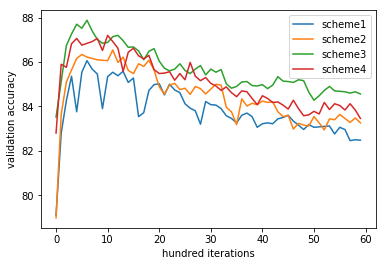

In [203]:
plt.figure()
plt.plot(list(range(len(validation_accuracy_list_model1))),validation_accuracy_list_model1, label = 'scheme1')
plt.plot(list(range(len(validation_accuracy_list_model2))),validation_accuracy_list_model2, label = 'scheme2')
plt.plot(list(range(len(validation_accuracy_list_model3))),validation_accuracy_list_model3, label = 'scheme3')
plt.plot(list(range(len(validation_accuracy_list_model4))),validation_accuracy_list_model4, label = 'scheme4')
plt.xlabel('hundred iterations')
plt.ylabel('validation accuracy')
plt.legend()

## Part2: Varing n=1,2,3,4

In [60]:
train_targets_class = pkl.load(open("train_targets_class.p", "rb"))
train_targets_values = pkl.load(open("train_targets_values.p", "rb"))
val_targets_class = pkl.load(open("val_targets_class.p", "rb"))
val_targets_values = pkl.load(open("val_targets_values.p", "rb"))
test_targets_class = pkl.load(open("test_targets_class.p", "rb"))
test_targets_values = pkl.load(open("test_targets_values.p", "rb"))

#convert 'pos' into 1, 'neg' into 0
train_targets_class = convert(train_targets_class)
val_targets_class = convert(val_targets_class)
test_targets_class = convert(test_targets_class)

In [62]:
experiment_file_list = dict(
    train_data_tokens = ['train_data_tokens_scheme3_1gram.p','train_data_tokens_scheme3_2gram.p','train_data_tokens_scheme3_3gram.p','train_data_tokens_scheme3_4gram.p'],
    all_train_tokens = ['all_train_tokens_scheme3_1gram.p','all_train_tokens_scheme3_2gram.p','all_train_tokens_scheme3_3gram.p','all_train_tokens_scheme3_4gram.p'],
    val_data_tokens = ['val_data_tokens_scheme3_1gram.p','val_data_tokens_scheme3_2gram.p','val_data_tokens_scheme3_3gram.p','val_data_tokens_scheme3_4gram.p'],
) 

In [85]:
experiment_validation_accuracy_list = [[],[],[],[]]

In [86]:
max_vocab_size = 50000
MAX_SENTENCE_LENGTH = 200
BATCH_SIZE = 25
emb_dim = 100
learning_rate = 0.01
num_epochs = 10 


for i in range(4):
    print('this is {} gram'.format(i+1))
    #load feature data for this experiment
    train_data_tokens = pkl.load(open(experiment_file_list['train_data_tokens'][i], "rb"))
    all_train_tokens = pkl.load(open(experiment_file_list['all_train_tokens'][i], "rb"))
    val_data_tokens = pkl.load(open(experiment_file_list['val_data_tokens'][i], "rb"))
    
    token2id, id2token = build_vocab(all_train_tokens)
    
    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    # double checking
    print ("Train dataset size is {}".format(len(train_data_indices)))
    print ("Val dataset size is {}".format(len(val_data_indices)))
    
    train_dataset = NewsGroupDataset(train_data_indices, train_targets_class)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets_class)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)


    model = BagOfWords(len(id2token), emb_dim)
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        for j, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if j > 0 and j % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                experiment_validation_accuracy_list[i].append(val_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, j+1, len(train_loader), val_acc))


    

this is 1 gram
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Epoch: [1/10], Step: [101/800], Validation Acc: 82.64
Epoch: [1/10], Step: [201/800], Validation Acc: 84.92
Epoch: [1/10], Step: [301/800], Validation Acc: 86.56
Epoch: [1/10], Step: [401/800], Validation Acc: 86.8
Epoch: [1/10], Step: [501/800], Validation Acc: 87.64
Epoch: [1/10], Step: [601/800], Validation Acc: 88.26
Epoch: [1/10], Step: [701/800], Validation Acc: 87.5
Epoch: [2/10], Step: [101/800], Validation Acc: 87.72
Epoch: [2/10], Step: [201/800], Validation Acc: 87.7
Epoch: [2/10], Step: [301/800], Validation Acc: 87.5
Epoch: [2/10], Step: [401/800], Validation Acc: 87.18
Epoch: [2/10], Step: [501/800], Validation Acc: 86.98
Epoch: [2/10], Step: [601/800], Validation Acc: 87.12
Epoch: [2/10], Step: [701/800], Validation Acc: 87.16
Epoch: [3/10], Step: [101/800], Validation Acc: 87.4
Epoch: [3/10], Step: [201/800], Validation Acc: 87.62
Epoch: [3/10], Step: [301/800], Validation Acc

Epoch: [2/10], Step: [101/800], Validation Acc: 88.64
Epoch: [2/10], Step: [201/800], Validation Acc: 88.26
Epoch: [2/10], Step: [301/800], Validation Acc: 88.6
Epoch: [2/10], Step: [401/800], Validation Acc: 88.16
Epoch: [2/10], Step: [501/800], Validation Acc: 88.22
Epoch: [2/10], Step: [601/800], Validation Acc: 88.38
Epoch: [2/10], Step: [701/800], Validation Acc: 87.92
Epoch: [3/10], Step: [101/800], Validation Acc: 88.14
Epoch: [3/10], Step: [201/800], Validation Acc: 88.08
Epoch: [3/10], Step: [301/800], Validation Acc: 88.12
Epoch: [3/10], Step: [401/800], Validation Acc: 88.24
Epoch: [3/10], Step: [501/800], Validation Acc: 87.72
Epoch: [3/10], Step: [601/800], Validation Acc: 87.62
Epoch: [3/10], Step: [701/800], Validation Acc: 87.82
Epoch: [4/10], Step: [101/800], Validation Acc: 87.64
Epoch: [4/10], Step: [201/800], Validation Acc: 87.48
Epoch: [4/10], Step: [301/800], Validation Acc: 87.64
Epoch: [4/10], Step: [401/800], Validation Acc: 87.58
Epoch: [4/10], Step: [501/800

In [91]:
len(experiment_validation_accuracy_list[2])

70

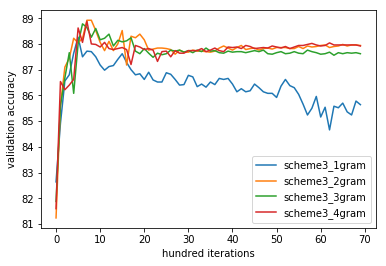

In [92]:
plt.figure()
plt.plot(list(range(len(experiment_validation_accuracy_list[0]))),experiment_validation_accuracy_list[0], label = 'scheme3_1gram')
plt.plot(list(range(len(experiment_validation_accuracy_list[0]))),experiment_validation_accuracy_list[1], label = 'scheme3_2gram')
plt.plot(list(range(len(experiment_validation_accuracy_list[0]))),experiment_validation_accuracy_list[2], label = 'scheme3_3gram')
plt.plot(list(range(len(experiment_validation_accuracy_list[0]))),experiment_validation_accuracy_list[3], label = 'scheme3_4gram')
plt.xlabel('hundred iterations')
plt.ylabel('validation accuracy')
plt.legend()

In [136]:
#print('max validation accuracy achieved for 1 gram is {}'.format(np.max(experiment_validation_accuracy_list[0])))
#print('max validation accuracy achieved for 2 gram is {}'.format(np.max(experiment_validation_accuracy_list[1])))
#print('max validation accuracy achieved for 3 gram is {}'.format(np.max(experiment_validation_accuracy_list[2])))
#print('max validation accuracy achieved for 4 gram is {}'.format(np.max(experiment_validation_accuracy_list[3])))

max validation accuracy achieved for 1 gram is 88.26
max validation accuracy achieved for 2 gram is 88.92
max validation accuracy achieved for 3 gram is 88.78
max validation accuracy achieved for 4 gram is 88.88


## Part3. Experiment with different vocabulary size

In [93]:
train_targets_class = pkl.load(open("train_targets_class.p", "rb"))
train_targets_values = pkl.load(open("train_targets_values.p", "rb"))
val_targets_class = pkl.load(open("val_targets_class.p", "rb"))
val_targets_values = pkl.load(open("val_targets_values.p", "rb"))
test_targets_class = pkl.load(open("test_targets_class.p", "rb"))
test_targets_values = pkl.load(open("test_targets_values.p", "rb"))

#convert 'pos' into 1, 'neg' into 0
train_targets_class = convert(train_targets_class)
val_targets_class = convert(val_targets_class)
test_targets_class = convert(test_targets_class)

In [94]:
train_data_tokens = pkl.load(open("train_data_tokens_scheme3_4gram.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_scheme3_4gram.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_scheme3_4gram.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_scheme3_4gram.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 16579672


In [100]:
experiment_maxvocab_size = [int(1e3), int(1e4), int(1e5), int(1e6)]

In [103]:
MAX_SENTENCE_LENGTH = 200
BATCH_SIZE = 32
emb_dim = 100
num_epochs = 10 

experiment_maxvocab_validation_accuracy_list = [[],[],[],[]]
for i in range(len(experiment_maxvocab_size)):
    max_vocab_size = experiment_maxvocab_size[i]
    token2id, id2token = build_vocab(all_train_tokens)
    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    test_data_indices = token2index_dataset(test_data_tokens)
    
    print ("Train dataset size is {}".format(len(train_data_indices)))
    print ("Val dataset size is {}".format(len(val_data_indices)))
    print ("Test dataset size is {}".format(len(test_data_indices)))
    
    train_dataset = NewsGroupDataset(train_data_indices, train_targets_class)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets_class)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

    model = BagOfWords(len(id2token), emb_dim)
    
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        for j, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if j > 0 and j % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                experiment_maxvocab_validation_accuracy_list[i].append(val_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, j+1, len(train_loader), val_acc))


    

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Epoch: [1/10], Step: [101/625], Validation Acc: 75.72
Epoch: [1/10], Step: [201/625], Validation Acc: 75.92
Epoch: [1/10], Step: [301/625], Validation Acc: 77.9
Epoch: [1/10], Step: [401/625], Validation Acc: 78.92
Epoch: [1/10], Step: [501/625], Validation Acc: 82.96
Epoch: [1/10], Step: [601/625], Validation Acc: 82.72
Epoch: [2/10], Step: [101/625], Validation Acc: 82.3
Epoch: [2/10], Step: [201/625], Validation Acc: 81.38
Epoch: [2/10], Step: [301/625], Validation Acc: 81.86
Epoch: [2/10], Step: [401/625], Validation Acc: 82.0
Epoch: [2/10], Step: [501/625], Validation Acc: 82.98
Epoch: [2/10], Step: [601/625], Validation Acc: 82.88
Epoch: [3/10], Step: [101/625], Validation Acc: 83.04
Epoch: [3/10], Step: [201/625], Validation Acc: 83.18
Epoch: [3/10], Step: [301/625], Validation Acc: 81.02
Epoch: [3/10], Step: [401/625], Validation Acc: 82.46
Epoch: [3/10], Step: [501/625], Validation Acc: 82.68
Epoch

Epoch: [5/10], Step: [501/625], Validation Acc: 88.5
Epoch: [5/10], Step: [601/625], Validation Acc: 88.48
Epoch: [6/10], Step: [101/625], Validation Acc: 88.48
Epoch: [6/10], Step: [201/625], Validation Acc: 88.38
Epoch: [6/10], Step: [301/625], Validation Acc: 88.48
Epoch: [6/10], Step: [401/625], Validation Acc: 88.46
Epoch: [6/10], Step: [501/625], Validation Acc: 88.44
Epoch: [6/10], Step: [601/625], Validation Acc: 88.52
Epoch: [7/10], Step: [101/625], Validation Acc: 88.48
Epoch: [7/10], Step: [201/625], Validation Acc: 88.52
Epoch: [7/10], Step: [301/625], Validation Acc: 88.56
Epoch: [7/10], Step: [401/625], Validation Acc: 88.62
Epoch: [7/10], Step: [501/625], Validation Acc: 88.56
Epoch: [7/10], Step: [601/625], Validation Acc: 88.52
Epoch: [8/10], Step: [101/625], Validation Acc: 88.5
Epoch: [8/10], Step: [201/625], Validation Acc: 88.64
Epoch: [8/10], Step: [301/625], Validation Acc: 88.56
Epoch: [8/10], Step: [401/625], Validation Acc: 88.58
Epoch: [8/10], Step: [501/625]

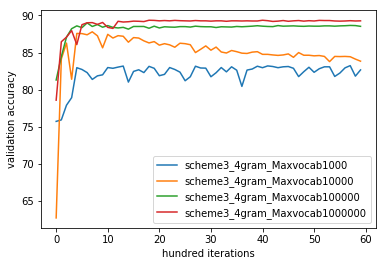

In [105]:
plt.figure()
plt.plot(list(range(len(experiment_maxvocab_validation_accuracy_list[0]))),experiment_maxvocab_validation_accuracy_list[0], label = 'scheme3_4gram_Maxvocab1000')
plt.plot(list(range(len(experiment_maxvocab_validation_accuracy_list[0]))),experiment_maxvocab_validation_accuracy_list[1], label = 'scheme3_4gram_Maxvocab10000')
plt.plot(list(range(len(experiment_maxvocab_validation_accuracy_list[0]))),experiment_maxvocab_validation_accuracy_list[2], label = 'scheme3_4gram_Maxvocab100000')
plt.plot(list(range(len(experiment_maxvocab_validation_accuracy_list[0]))),experiment_maxvocab_validation_accuracy_list[3], label = 'scheme3_4gram_Maxvocab1000000')
plt.xlabel('hundred iterations')
plt.ylabel('validation accuracy')
plt.legend()

## Experiment with Embedding size

In [116]:
train_targets_class = pkl.load(open("train_targets_class.p", "rb"))
train_targets_values = pkl.load(open("train_targets_values.p", "rb"))
val_targets_class = pkl.load(open("val_targets_class.p", "rb"))
val_targets_values = pkl.load(open("val_targets_values.p", "rb"))
test_targets_class = pkl.load(open("test_targets_class.p", "rb"))
test_targets_values = pkl.load(open("test_targets_values.p", "rb"))

#convert 'pos' into 1, 'neg' into 0
train_targets_class = convert(train_targets_class)
val_targets_class = convert(val_targets_class)
test_targets_class = convert(test_targets_class)

In [117]:
train_data_tokens = pkl.load(open("train_data_tokens_scheme3_4gram.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_scheme3_4gram.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_scheme3_4gram.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_scheme3_4gram.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 16579672


In [130]:
experiment_embed_size = [50, 100, 200, 300, 500]

In [131]:
BATCH_SIZE = 32
MAX_SENTENCE_LENGTH = 200
max_vocab_size = 100000
num_epochs = 10 
learning_rate = 0.01


token2id, id2token = build_vocab(all_train_tokens)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))
print('\n')

train_dataset = NewsGroupDataset(train_data_indices, train_targets_class)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                       batch_size=BATCH_SIZE,
                                       collate_fn=newsgroup_collate_func,
                                       shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets_class)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                       batch_size=BATCH_SIZE,
                                       collate_fn=newsgroup_collate_func,
                                       shuffle=True)

    
experiment_embed_validation_accuracy_list = [[],[],[],[],[]]
for i in range(len(experiment_embed_size)):
    emb_dim = experiment_embed_size[i]
    
    model = BagOfWords(len(id2token), emb_dim)
    
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        for j, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if j > 0 and j % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                experiment_embed_validation_accuracy_list[i].append(val_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, j+1, len(train_loader), val_acc))


    

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


Epoch: [1/10], Step: [101/625], Validation Acc: 82.1
Epoch: [1/10], Step: [201/625], Validation Acc: 86.02
Epoch: [1/10], Step: [301/625], Validation Acc: 87.64
Epoch: [1/10], Step: [401/625], Validation Acc: 88.32
Epoch: [1/10], Step: [501/625], Validation Acc: 88.98
Epoch: [1/10], Step: [601/625], Validation Acc: 89.26
Epoch: [2/10], Step: [101/625], Validation Acc: 88.96
Epoch: [2/10], Step: [201/625], Validation Acc: 89.0
Epoch: [2/10], Step: [301/625], Validation Acc: 88.88
Epoch: [2/10], Step: [401/625], Validation Acc: 88.64
Epoch: [2/10], Step: [501/625], Validation Acc: 88.38
Epoch: [2/10], Step: [601/625], Validation Acc: 88.62
Epoch: [3/10], Step: [101/625], Validation Acc: 88.86
Epoch: [3/10], Step: [201/625], Validation Acc: 88.66
Epoch: [3/10], Step: [301/625], Validation Acc: 88.66
Epoch: [3/10], Step: [401/625], Validation Acc: 88.74
Epoch: [3/10], Step: [501/625], Validation Acc: 88.86
Ep

Epoch: [6/10], Step: [201/625], Validation Acc: 89.02
Epoch: [6/10], Step: [301/625], Validation Acc: 89.06
Epoch: [6/10], Step: [401/625], Validation Acc: 89.16
Epoch: [6/10], Step: [501/625], Validation Acc: 88.82
Epoch: [6/10], Step: [601/625], Validation Acc: 89.14
Epoch: [7/10], Step: [101/625], Validation Acc: 89.1
Epoch: [7/10], Step: [201/625], Validation Acc: 89.12
Epoch: [7/10], Step: [301/625], Validation Acc: 89.14
Epoch: [7/10], Step: [401/625], Validation Acc: 89.12
Epoch: [7/10], Step: [501/625], Validation Acc: 89.1
Epoch: [7/10], Step: [601/625], Validation Acc: 89.18
Epoch: [8/10], Step: [101/625], Validation Acc: 89.1
Epoch: [8/10], Step: [201/625], Validation Acc: 89.1
Epoch: [8/10], Step: [301/625], Validation Acc: 89.1
Epoch: [8/10], Step: [401/625], Validation Acc: 89.14
Epoch: [8/10], Step: [501/625], Validation Acc: 89.06
Epoch: [8/10], Step: [601/625], Validation Acc: 89.1
Epoch: [9/10], Step: [101/625], Validation Acc: 89.06
Epoch: [9/10], Step: [201/625], Va

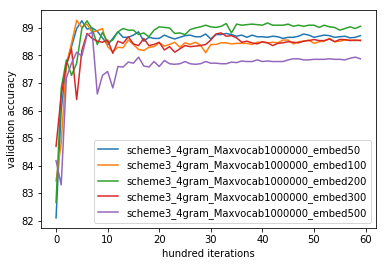

In [132]:
plt.figure()
plt.plot(list(range(len(experiment_embed_validation_accuracy_list[0]))),experiment_embed_validation_accuracy_list[0], label = 'scheme3_4gram_Maxvocab100000_embed50')
plt.plot(list(range(len(experiment_embed_validation_accuracy_list[0]))),experiment_embed_validation_accuracy_list[1], label = 'scheme3_4gram_Maxvocab100000_embed100')
plt.plot(list(range(len(experiment_embed_validation_accuracy_list[0]))),experiment_embed_validation_accuracy_list[2], label = 'scheme3_4gram_Maxvocab100000_embed200')
plt.plot(list(range(len(experiment_embed_validation_accuracy_list[0]))),experiment_embed_validation_accuracy_list[3], label = 'scheme3_4gram_Maxvocab100000_embed300')
plt.plot(list(range(len(experiment_embed_validation_accuracy_list[0]))),experiment_embed_validation_accuracy_list[4], label = 'scheme3_4gram_Maxvocab100000_embed500')
plt.xlabel('hundred iterations')
plt.ylabel('validation accuracy')
plt.legend()

In [ ]:
#conclusion: choose embed200

In [146]:
print('max validation accuracy achieved for embed50 is {}'.format(np.max(experiment_embed_validation_accuracy_list[0])))
print('max validation accuracy achieved for embed100 is {}'.format(np.max(experiment_embed_validation_accuracy_list[1])))
print('max validation accuracy achieved for embed200 is {}'.format(np.max(experiment_embed_validation_accuracy_list[2])))
print('max validation accuracy achieved for embed300 is {}'.format(np.max(experiment_embed_validation_accuracy_list[3])))
print('max validation accuracy achieved for embed500 is {}'.format(np.max(experiment_embed_validation_accuracy_list[3])))

max validation accuracy achieved for embed50 is 89.26
max validation accuracy achieved for embed100 is 89.28
max validation accuracy achieved for embed200 is 89.26
max validation accuracy achieved for embed300 is 88.82
max validation accuracy achieved for embed500 is 88.82


## Experiment with Optimizer

In [143]:
train_targets_class = pkl.load(open("train_targets_class.p", "rb"))
train_targets_values = pkl.load(open("train_targets_values.p", "rb"))
val_targets_class = pkl.load(open("val_targets_class.p", "rb"))
val_targets_values = pkl.load(open("val_targets_values.p", "rb"))
test_targets_class = pkl.load(open("test_targets_class.p", "rb"))
test_targets_values = pkl.load(open("test_targets_values.p", "rb"))

#convert 'pos' into 1, 'neg' into 0
train_targets_class = convert(train_targets_class)
val_targets_class = convert(val_targets_class)
test_targets_class = convert(test_targets_class)

In [144]:
train_data_tokens = pkl.load(open("train_data_tokens_scheme3_4gram.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_scheme3_4gram.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_scheme3_4gram.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_scheme3_4gram.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 16579672


In [155]:
MAX_SENTENCE_LENGTH = 200
BATCH_SIZE = 32
max_vocab_size = 100000
emb_dim = 200
num_epochs = 10 
learning_rate = 0.01


token2id, id2token = build_vocab(all_train_tokens)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))
print('\n')

train_dataset = NewsGroupDataset(train_data_indices, train_targets_class)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                       batch_size=BATCH_SIZE,
                                       collate_fn=newsgroup_collate_func,
                                       shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets_class)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                       batch_size=BATCH_SIZE,
                                       collate_fn=newsgroup_collate_func,
                                       shuffle=True)

   
experiment_optimizer_validation_accuracy_list = [[],[]]
optimizer_time = []
for i in range(len(experiment_optimizer)):
    
    model = BagOfWords(len(id2token), emb_dim) 
    criterion = torch.nn.CrossEntropyLoss()  
    if i ==0:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif i == 1:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    start_time = time.time()
    for epoch in range(num_epochs):
        for j, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if j > 0 and j % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                experiment_optimizer_validation_accuracy_list[i].append(val_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, j+1, len(train_loader), val_acc))
    end_time = time.time()
    optimizer_time.append(end_time - start_time)
        

    

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


Epoch: [1/10], Step: [101/625], Validation Acc: 83.82
Epoch: [1/10], Step: [201/625], Validation Acc: 86.98
Epoch: [1/10], Step: [301/625], Validation Acc: 81.24
Epoch: [1/10], Step: [401/625], Validation Acc: 87.98
Epoch: [1/10], Step: [501/625], Validation Acc: 88.7
Epoch: [1/10], Step: [601/625], Validation Acc: 87.94
Epoch: [2/10], Step: [101/625], Validation Acc: 89.02
Epoch: [2/10], Step: [201/625], Validation Acc: 88.94
Epoch: [2/10], Step: [301/625], Validation Acc: 88.82
Epoch: [2/10], Step: [401/625], Validation Acc: 88.0
Epoch: [2/10], Step: [501/625], Validation Acc: 87.88
Epoch: [2/10], Step: [601/625], Validation Acc: 87.92
Epoch: [3/10], Step: [101/625], Validation Acc: 87.88
Epoch: [3/10], Step: [201/625], Validation Acc: 88.0
Epoch: [3/10], Step: [301/625], Validation Acc: 88.28
Epoch: [3/10], Step: [401/625], Validation Acc: 88.06
Epoch: [3/10], Step: [501/625], Validation Acc: 88.24
Epo

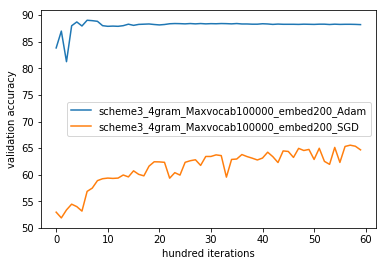

In [156]:
plt.figure()
plt.plot(list(range(len(experiment_optimizer_validation_accuracy_list[0]))),experiment_optimizer_validation_accuracy_list[0], label = 'scheme3_4gram_Maxvocab100000_embed200_Adam')
plt.plot(list(range(len(experiment_optimizer_validation_accuracy_list[0]))),experiment_optimizer_validation_accuracy_list[1], label = 'scheme3_4gram_Maxvocab100000_embed200_SGD')
plt.xlabel('hundred iterations')
plt.ylabel('validation accuracy')
plt.legend()

In [157]:
print('it takes Adam {} seconds to train 10 epochs'.format(optimizer_time[0]))
print('it takes SGD {} seconds to train 10 epochs'.format(optimizer_time[1]))

it takes Adam 1381.2450008392334 seconds to train 10 epochs
it takes SGD 442.7786819934845 seconds to train 10 epochs


## Experiment with Learning rate

In [158]:
train_targets_class = pkl.load(open("train_targets_class.p", "rb"))
train_targets_values = pkl.load(open("train_targets_values.p", "rb"))
val_targets_class = pkl.load(open("val_targets_class.p", "rb"))
val_targets_values = pkl.load(open("val_targets_values.p", "rb"))
test_targets_class = pkl.load(open("test_targets_class.p", "rb"))
test_targets_values = pkl.load(open("test_targets_values.p", "rb"))

#convert 'pos' into 1, 'neg' into 0
train_targets_class = convert(train_targets_class)
val_targets_class = convert(val_targets_class)
test_targets_class = convert(test_targets_class)

In [159]:
train_data_tokens = pkl.load(open("train_data_tokens_scheme3_4gram.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_scheme3_4gram.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_scheme3_4gram.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_scheme3_4gram.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 16579672


In [160]:
experiment_lr = [0.001, 0.01, 0.05, 0.1]

In [161]:
BATCH_SIZE = 32
max_vocab_size = 100000
num_epochs = 5 
emb_dim = 200
MAX_SENTENCE_LENGTH = 200


token2id, id2token = build_vocab(all_train_tokens)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))
print('\n')

train_dataset = NewsGroupDataset(train_data_indices, train_targets_class)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                       batch_size=BATCH_SIZE,
                                       collate_fn=newsgroup_collate_func,
                                       shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets_class)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                       batch_size=BATCH_SIZE,
                                       collate_fn=newsgroup_collate_func,
                                       shuffle=True)

    
experiment_lr_validation_accuracy_list = [[],[],[],[]]
for i in range(len(experiment_lr)):
    learning_rate = experiment_lr[i]
    print('current learning_rate is {}:'.format(learning_rate))
    model = BagOfWords(len(id2token), emb_dim)
    
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        for j, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if j > 0 and j % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                experiment_lr_validation_accuracy_list[i].append(val_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, j+1, len(train_loader), val_acc))


    

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


current learning_rate is 0.001:
Epoch: [1/5], Step: [101/625], Validation Acc: 62.72
Epoch: [1/5], Step: [201/625], Validation Acc: 63.38
Epoch: [1/5], Step: [301/625], Validation Acc: 79.22
Epoch: [1/5], Step: [401/625], Validation Acc: 82.06
Epoch: [1/5], Step: [501/625], Validation Acc: 84.04
Epoch: [1/5], Step: [601/625], Validation Acc: 84.96
Epoch: [2/5], Step: [101/625], Validation Acc: 85.96
Epoch: [2/5], Step: [201/625], Validation Acc: 86.8
Epoch: [2/5], Step: [301/625], Validation Acc: 87.0
Epoch: [2/5], Step: [401/625], Validation Acc: 87.36
Epoch: [2/5], Step: [501/625], Validation Acc: 87.6
Epoch: [2/5], Step: [601/625], Validation Acc: 87.94
Epoch: [3/5], Step: [101/625], Validation Acc: 88.22
Epoch: [3/5], Step: [201/625], Validation Acc: 87.94
Epoch: [3/5], Step: [301/625], Validation Acc: 88.68
Epoch: [3/5], Step: [401/625], Validation Acc: 88.78
Epoch: [3/5], Step: [501/625], Validation

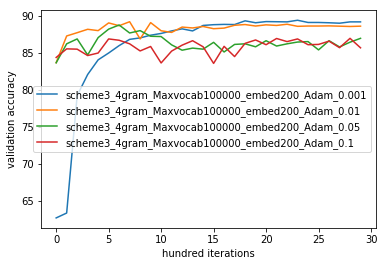

In [164]:
plt.figure()
plt.plot(list(range(len(experiment_lr_validation_accuracy_list[0]))),experiment_lr_validation_accuracy_list[0], label = 'scheme3_4gram_Maxvocab100000_embed200_Adam_0.001')
plt.plot(list(range(len(experiment_lr_validation_accuracy_list[0]))),experiment_lr_validation_accuracy_list[1], label = 'scheme3_4gram_Maxvocab100000_embed200_Adam_0.01')
plt.plot(list(range(len(experiment_lr_validation_accuracy_list[0]))),experiment_lr_validation_accuracy_list[2], label = 'scheme3_4gram_Maxvocab100000_embed200_Adam_0.05')
plt.plot(list(range(len(experiment_lr_validation_accuracy_list[0]))),experiment_lr_validation_accuracy_list[3], label = 'scheme3_4gram_Maxvocab100000_embed200_Adam_0.1')
plt.xlabel('hundred iterations')
plt.ylabel('validation accuracy')
plt.legend()

## Experiment with linear annealing learning rate 

In [158]:
train_targets_class = pkl.load(open("train_targets_class.p", "rb"))
train_targets_values = pkl.load(open("train_targets_values.p", "rb"))
val_targets_class = pkl.load(open("val_targets_class.p", "rb"))
val_targets_values = pkl.load(open("val_targets_values.p", "rb"))
test_targets_class = pkl.load(open("test_targets_class.p", "rb"))
test_targets_values = pkl.load(open("test_targets_values.p", "rb"))

#convert 'pos' into 1, 'neg' into 0
train_targets_class = convert(train_targets_class)
val_targets_class = convert(val_targets_class)
test_targets_class = convert(test_targets_class)

In [159]:
train_data_tokens = pkl.load(open("train_data_tokens_scheme3_4gram.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_scheme3_4gram.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_scheme3_4gram.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_scheme3_4gram.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 16579672


In [180]:
BATCH_SIZE = 32
max_vocab_size = 100000
num_epochs = 5 
emb_dim = 200
MAX_SENTENCE_LENGTH = 200


token2id, id2token = build_vocab(all_train_tokens)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))
print('\n')

train_dataset = NewsGroupDataset(train_data_indices, train_targets_class)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                       batch_size=BATCH_SIZE,
                                       collate_fn=newsgroup_collate_func,
                                       shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets_class)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                       batch_size=BATCH_SIZE,
                                       collate_fn=newsgroup_collate_func,
                                       shuffle=True)

    
experiment_lr_linear_validation_accuracy_list = []
learning_rate = 0.1
model = BagOfWords(len(id2token), emb_dim)
criterion = torch.nn.CrossEntropyLoss()  

#every 300 iteration reduce learning rate by 0.005
count = 0
for epoch in range(num_epochs):
    for j, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        count +=1
        if count % 300 == 0 :
            learning_rate = learning_rate - 0.005 
            print('current learning_rate is {}'.format(learning_rate))
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 300 iterations
        if j > 0 and j % 300 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            experiment_lr_linear_validation_accuracy_list.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, j+1, len(train_loader), val_acc))


    

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


current learning_rate is 0.095
Epoch: [1/5], Step: [301/625], Validation Acc: 79.3
current learning_rate is 0.09
Epoch: [1/5], Step: [601/625], Validation Acc: 84.58
current learning_rate is 0.08499999999999999
Epoch: [2/5], Step: [301/625], Validation Acc: 86.94
current learning_rate is 0.07999999999999999
Epoch: [2/5], Step: [601/625], Validation Acc: 82.88
current learning_rate is 0.07499999999999998
Epoch: [3/5], Step: [301/625], Validation Acc: 87.1
current learning_rate is 0.06999999999999998
Epoch: [3/5], Step: [601/625], Validation Acc: 86.28
current learning_rate is 0.06499999999999997
Epoch: [4/5], Step: [301/625], Validation Acc: 86.5
current learning_rate is 0.05999999999999998
Epoch: [4/5], Step: [601/625], Validation Acc: 87.42
current learning_rate is 0.05499999999999998
Epoch: [5/5], Step: [301/625], Validation Acc: 86.94
current learning_rate is 0.04999999999999998
Epoch: [5/5], Step: [60

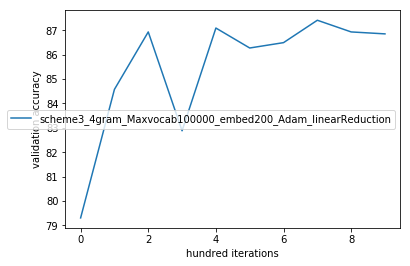

In [182]:
plt.plot(list(range(len(experiment_lr_linear_validation_accuracy_list))),experiment_lr_linear_validation_accuracy_list, label = 'scheme3_4gram_Maxvocab100000_embed200_Adam_linearReduction')
plt.xlabel('hundred iterations')
plt.ylabel('validation accuracy')
plt.legend()


## Final Model

In [165]:
train_targets_class = pkl.load(open("train_targets_class.p", "rb"))
train_targets_values = pkl.load(open("train_targets_values.p", "rb"))
val_targets_class = pkl.load(open("val_targets_class.p", "rb"))
val_targets_values = pkl.load(open("val_targets_values.p", "rb"))
test_targets_class = pkl.load(open("test_targets_class.p", "rb"))
test_targets_values = pkl.load(open("test_targets_values.p", "rb"))

#convert 'pos' into 1, 'neg' into 0
train_targets_class = convert(train_targets_class)
val_targets_class = convert(val_targets_class)
test_targets_class = convert(test_targets_class)


In [166]:
train_data_tokens = pkl.load(open("train_data_tokens_scheme3_4gram.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_scheme3_4gram.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_scheme3_4gram.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_scheme3_4gram.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 16579672


In [170]:
#best configuration from above experiment:

#set batch_size to a large number, but save only the best model according to validation
num_epochs = 50
BATCH_SIZE = 32
max_vocab_size = 100000
emb_dim = 200
learning_rate = 0.001
MAX_SENTENCE_LENGTH = 200


token2id, id2token = build_vocab(all_train_tokens)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))
print('\n')

train_dataset = NewsGroupDataset(train_data_indices, train_targets_class)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                       batch_size=BATCH_SIZE,
                                       collate_fn=newsgroup_collate_func,
                                       shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets_class)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                       batch_size=BATCH_SIZE,
                                       collate_fn=newsgroup_collate_func,
                                       shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets_class)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)
    

model = BagOfWords(len(id2token), emb_dim)
    
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
best_acc = 0 

validation_accuracy = []
training_accuracy = []
for epoch in range(num_epochs):
    for j, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if j > 0 and j % 300 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            validation_accuracy.append(val_acc)
            training_accuracy.append(train_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, j+1, len(train_loader), val_acc))
            if val_acc > best_error:
                best_error = val_acc
                print('find new record, save the model!')
                torch.save(model.state_dict(), 'current_best_model.pkl')
                
            




Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


Epoch: [1/50], Step: [301/625], Validation Acc: 76.08
Epoch: [1/50], Step: [601/625], Validation Acc: 84.96
find new record, save the model!
Epoch: [2/50], Step: [301/625], Validation Acc: 87.18
find new record, save the model!
Epoch: [2/50], Step: [601/625], Validation Acc: 88.2
find new record, save the model!
Epoch: [3/50], Step: [301/625], Validation Acc: 88.76
find new record, save the model!
Epoch: [3/50], Step: [601/625], Validation Acc: 88.9
find new record, save the model!
Epoch: [4/50], Step: [301/625], Validation Acc: 89.22
find new record, save the model!
Epoch: [4/50], Step: [601/625], Validation Acc: 89.3
find new record, save the model!
Epoch: [5/50], Step: [301/625], Validation Acc: 89.5
find new record, save the model!
Epoch: [5/50], Step: [601/625], Validation Acc: 89.42
Epoch: [6/50], Step: [301/625], Validation Acc: 89.3
Epoch: [6/50], Step: [601/625], Validation Acc: 89.54
find new re

In [171]:
#load the model for testing
best_model = BagOfWords(len(id2token), emb_dim)
best_model.load_state_dict(torch.load('current_best_model.pkl'))

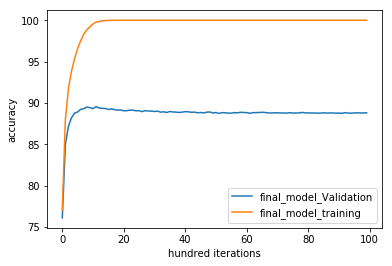

In [183]:
plt.figure()
plt.plot(list(range(len(validation_accuracy))),validation_accuracy, label = 'final_model_Validation')
plt.plot(list(range(len(training_accuracy))),training_accuracy, label = 'final_model_training')
plt.xlabel('hundred iterations')
plt.ylabel('accuracy')
plt.legend()

In [172]:
correct = 0
total = 0
best_model.eval()
for data, lengths, labels in test_loader:
    data_batch, length_batch, label_batch = data, lengths, labels
    outputs = F.softmax(best_model(data_batch, length_batch), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]

    total += labels.size(0)
    correct += predicted.eq(labels.view_as(predicted)).sum().item()
    acc = 100 * correct / total
    

In [174]:
print('testing accuracy: {} '.format(acc))

testing accuracy: 87.996 


In [191]:
#print 3 correct and 3 incorrect prediction of the final model on validation set
count = 0
for data, lengths, labels in val_loader:
    if count == 1:
        break
    data_batch, length_batch, label_batch = data, lengths, labels
    print('data_batch is {}'.format(data_batch))
    print('label_batch is {}'.format(label_batch))
    
    outputs = F.softmax(best_model(data_batch, length_batch), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    print('predicted labels is {}'.format(predicted.view_as(labels)))
    
    print((predicted.view_as(labels)==labels))
    
    count+=1
    

data_batch is tensor([[   14,     5,  3045,  ...,  6304, 14965, 16311],
        [ 3323,  1034,     3,  ...,     1,     1, 51926],
        [ 1516,  5450,  4873,  ...,     1,     1,     1],
        ...,
        [   67,     3,  3523,  ..., 43069,     1,     1],
        [    2,     8,    61,  ...,  4623, 57279,  1251],
        [ 2303,     2,   638,  ...,     1,     1,  1852]])
label_batch is tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 1])
predicted labels is tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 1, 1])
tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1], dtype=torch.uint8)


In [201]:
#map back id to tokens
#so 3 incorrect prediction is data_batch[1], data_batch[9], data_batch[20]
#   3 correct prediction is data_batch[0], data_batch[2], data_batch[3]                          

incorrect_example = [1, 9, 20]
correct_example = [0, 2, 3]

In [206]:
#1: pos, 0:neg
for i in incorrect_example:
    sent_ex = [id2token[j] for j in data_batch[i]]
    print('example:')
    print('true label is {} predicted to be {}'.format(label_batch[i],predicted[i].data[0]))
    print('\n')
    print(' '.join(sent_ex))
    print('\n')

example:
true label is 0 predicted to be 1


since review 's film screening 's seen decade 's ago i 'd like add recent film open 's stock footage <unk> 's bombing germany film cut 's <unk> werner 's <unk> captain <unk> character aide running cover making way hitler 's <unk> bunker inside <unk> bunker staff personnel film cut 's conference scene 's <unk> <unk> giving decent impression adolf hitler <unk> officer 's ultimate victory werner 's character shown slowly coming realize bunker <unk> 's caught fantasy world non bunker event 's depicted notable <unk> subway system prevent russian advance minor subplot involving young member <unk> unit 's family 's difficulty surviving film suffer 's number detail inaccuracies german film 10 year 's ww2 included actor portraying goebbels willy krause wear 's uniform hitler including arm <unk> goebbels wore brown nazi party uniform <unk> <unk> ss soldier 's wear german army <unk> documented scene hitler <unk> iron cross boy 's hitler youth shown hav

In [207]:
#1: pos, 0:neg
for i in correct_example:
    sent_ex = [id2token[j] for j in data_batch[i]]
    print('example:')
    print('true label is {} predicted to be {}'.format(label_batch[i],predicted[i].data[0]))
    print('\n')
    print(' '.join(sent_ex))
    print('\n')

example:
true label is 0 predicted to be 0


this movie absolute worst movie seen my sister boyfriend went rent zodiac 2007 got accident thought joke actual movie terrible waiting scary movie actual facts real zodiac killer the filmmakers clearly n't bother research killings ... liked ... decided write script true i upset n't realize n't movie sooner i try like movie n't hate movies ... ... if given stars definitely 1 10 this_movie movie_must must_have have_been been_the the_absolute absolute_worst worst_movie movie_i i_have have_ever ever_seen seen_my my_sister sister_and and_her her_boyfriend <unk> went_to to_rent <unk> <unk> <unk> and_got got_this this_one one_by by_accident <unk> thought_it it_was was_a a_joke <unk> before_the the_actual actual_movie movie_this this_was was_terrible terrible_i i_was was_waiting waiting_for for_it it_to to_get <unk> scary_and and_it it_never never_did did_this this_movie movie_had had_not <unk> <unk> <unk> about_the the_real <unk> zodiac_killer kill